In [1]:
import tensorflow as tf
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
!pip install kaggle

In [4]:
!kaggle datasets download -d tubagusaldi/datasetrempah2

Dataset URL: https://www.kaggle.com/datasets/tubagusaldi/datasetrempah2
License(s): Apache 2.0
 98% 150M/152M [00:10<00:00, 19.8MB/s]
100% 152M/152M [00:10<00:00, 15.9MB/s]


In [6]:
local_zip = r'/content/datasetrempah2.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(r'/content/')
zip_ref.close()

In [7]:
pip install split-folders

In [8]:
capstone_path = '/content/myDataset'

In [9]:
import splitfolders

input_folder = capstone_path
output_folder = 'dataset_split'
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 4569 files [00:00, 5519.87 files/s]


In [10]:
def custom_preprocessing(image):
    # Convert image to tensor
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Randomly adjust brightness
    image = tf.image.random_brightness(image, max_delta=0.2)
    # Randomly adjust contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

In [11]:
base_dir = capstone_path
train_dir = os.path.join(base_dir, '/content/dataset_split/train')
validation_dir = os.path.join(base_dir, '/content/dataset_split/val')

In [12]:
# base_dir = capstone_path
# train_dir = 'dataset_split/train'
# validation_dir = 'dataset_split/val'

In [13]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=custom_preprocessing,
    fill_mode='nearest'
)

In [14]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 3650 images belonging to 12 classes.


In [16]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 919 images belonging to 12 classes.


In [17]:
# Print number of classes
num_classes = len(train_generator.class_indices)
print(f'Number of classes: {num_classes}')

Number of classes: 12


In [18]:
# Load VGG16 model, excluding the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [19]:

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [20]:
# Freeze base model layers
base_model.trainable = False

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [22]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [23]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
114/114 [==============================] - 51s 375ms/step - loss: 1.5396 - accuracy: 0.5019 - val_loss: 0.8965 - val_accuracy: 0.7344
Epoch 2/50
114/114 [==============================] - 43s 377ms/step - loss: 0.9461 - accuracy: 0.6924 - val_loss: 0.6685 - val_accuracy: 0.7980
Epoch 3/50
114/114 [==============================] - 42s 369ms/step - loss: 0.7959 - accuracy: 0.7430 - val_loss: 0.6075 - val_accuracy: 0.8058
Epoch 4/50
114/114 [==============================] - 42s 368ms/step - loss: 0.7269 - accuracy: 0.7684 - val_loss: 0.5542 - val_accuracy: 0.8382
Epoch 5/50
114/114 [==============================] - 42s 367ms/step - loss: 0.6213 - accuracy: 0.7949 - val_loss: 0.4819 - val_accuracy: 0.8516
Epoch 6/50
114/114 [==============================] - 42s 369ms/step - loss: 0.5921 - accuracy: 0.8027 - val_loss: 0.4437 - val_accuracy: 0.8605
Epoch 7/50
114/114 [==============================] - 42s 366ms/step - loss: 0.5654 - accuracy: 0.8220 - val_loss: 0.4779 - val_ac

In [24]:
# Plotting the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [25]:
epochs = range(len(acc))

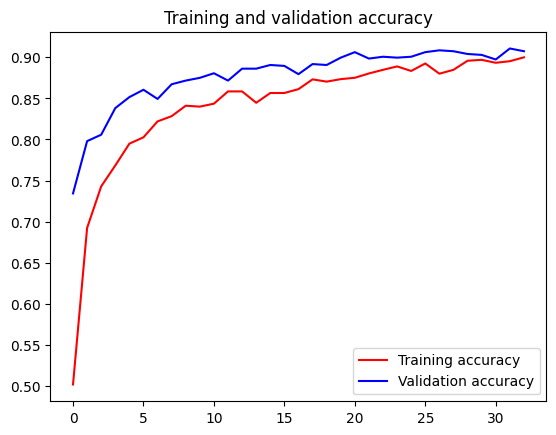

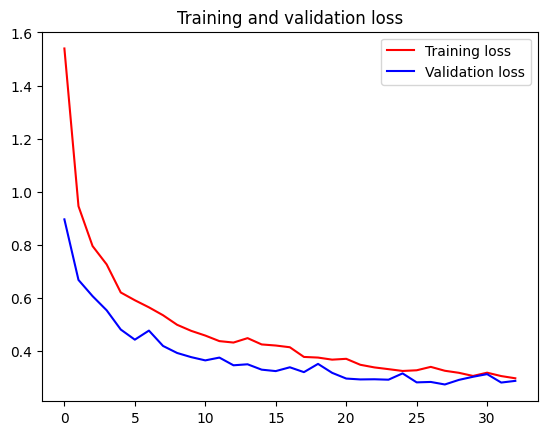

In [26]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
# Save the model
model_path = 'spice_classification_model.h5'
model.save(model_path)
print(f'Model saved to {model_path}')


Model saved to spice_classification_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:

# Load the model
loaded_model = tf.keras.models.load_model(model_path)
print('Model loaded from disk.')

Model loaded from disk.


In [94]:
# Predict on a new image
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model, class_indices):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_label = list(class_indices.keys())[list(class_indices.values()).index(class_idx)]

    return class_label

# Example usage
example_image_path = '/content/test/pala 5.jpg'
predicted_class = predict_image(example_image_path, loaded_model, train_generator.class_indices)
print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 0s 18ms/step
Predicted class: pala


In [96]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 123.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 43.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
  

In [97]:
import tensorflowjs as tfjs

# Specify the saved model path and the output directory
saved_model_path = model_path
output_dir = '/content/tensorflow js'

# Convert the model to TensorFlow.js format
tfjs.converters.save_keras_model(model, output_dir)

NotFoundError: /usr/local/lib/python3.10/dist-packages/tensorflow_decision_forests/tensorflow/ops/inference/inference.so: undefined symbol: _ZN10tensorflow20OpKernelConstruction21CtxFailureWithWarningEPKciRKN4absl12lts_202308026StatusE

In [98]:
!tensorflowjs_converter --input_format=keras {model_path} ./

2024-06-04 03:27:26.243302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [99]:
!zip Model.zip *.bin model.json

  adding: group1-shard10of15.bin (deflated 7%)
  adding: group1-shard11of15.bin (deflated 7%)
  adding: group1-shard12of15.bin (deflated 7%)
  adding: group1-shard13of15.bin (deflated 7%)
  adding: group1-shard14of15.bin (deflated 7%)
  adding: group1-shard15of15.bin (deflated 7%)
  adding: group1-shard1of15.bin (deflated 7%)
  adding: group1-shard2of15.bin (deflated 7%)
  adding: group1-shard3of15.bin (deflated 7%)
  adding: group1-shard4of15.bin (deflated 7%)
  adding: group1-shard5of15.bin (deflated 7%)
  adding: group1-shard6of15.bin (deflated 7%)
  adding: group1-shard7of15.bin (deflated 7%)
  adding: group1-shard8of15.bin (deflated 7%)
  adding: group1-shard9of15.bin (deflated 7%)
  adding: model.json (deflated 91%)


In [100]:
# Load the Keras model
model = tf.keras.models.load_model('spice_classification_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('spice_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model converted to TensorFlow Lite format and saved as spice_classification_model.tflite')

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x784fec505e10>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x784fec505e10>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model converted to TensorFlow Lite format and saved as spice_classification_model.tflite
